In [71]:
import numpy as np
import pandas as pd
import math
import matplotlib
from matplotlib import pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

### Load Data

In [72]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
AAPL = pd.read_csv('AAPL.csv')
AAPL['Date'] = AAPL['Date'].astype('datetime64[ns]')
AAPL

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800
...,...,...,...,...,...,...,...
2802,2021-02-22,128.009995,129.720001,125.599998,126.000000,126.000000,103607600
2803,2021-02-23,123.760002,126.709999,118.389999,125.860001,125.860001,157859100
2804,2021-02-24,124.940002,125.559998,122.230003,125.349998,125.349998,110691500
2805,2021-02-25,124.680000,126.459999,120.540001,120.989998,120.989998,147306500


### ARIMA Training 

In [108]:
def arima_calc(date,data):
    #Set Date Range
    df_log = np.log(data['Close'][0:date])
    train_data = df_log[3:int(len(df_log))]
    #Get parameters
    model_autoARIMA = auto_arima(train_data, #start_p=1, start_q=1,
                      #test='adf',       # use adftest to find optimal 'd'
                      #max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      start_P=1, 
                      #D=0, 
                      #trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    #Fit Model
    model = ARIMA(train_data, order=model_autoARIMA.order)  
    fitted = model.fit(disp=-1) 
    # Forecast
    fc, se, conf = fitted.forecast(1, alpha=0.05)  # 95% conf
    return fc



## Building The Agent

In [109]:
# Determine when to excecute the strategies
class ARIMA_Agent:
    
    def __init__(self, wallet):
        self.data = None
        self.wallet = wallet # Amount of cash in hand
        self.portfolio = 0 # Company stock count
        self.current_market = None
        self.history = [[[],[]],[[],[]]] # 1st arr: Buy history; 2nd arr: sell history. [date, price]
        self.sma_diff = [] #
    
    # Check if the agent can buy the stock
    # Returns: Boolean. True if can buy, False if not
    def can_buy(self, unit):
        if unit == -1:
            if self.wallet >= self.current_market['Open']:
                return True
        else:
            if self.wallet >= unit*self.current_market['Open']:
                return True
        return False
    
    # Check if the agent can sell the stock
    # Returns: Boolean. True if can sell, False if not
    def can_sell(self, unit):
        if unit == -1:
            if self.portfolio > 0:
                return True
        else:
            if self.portfolio >= unit:
                return True
        return False
    
    # Buys x unit of stock. -1 to spend all
    def buy(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = math.floor(self.wallet/current_price)
        self.wallet -= unit*current_price
        self.portfolio += unit
        self.history[0][0].append(self.current_market['Date'])
        self.history[0][1].append(current_price)
    
    # Sells x unit of stock. -1 to sell all
    def sell(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = self.portfolio
        self.wallet += unit*current_price
        self.portfolio -= unit
        self.history[1][0].append(self.current_market['Date'])
        self.history[1][1].append(current_price)
    
    # Computes the total balance: wallet + holdings
    def total_balance(self):
        current_price = self.current_market['Open'] # price 1 stock
        return self.wallet + current_price*self.portfolio
    
    def ARIMA_func(self):
        date = self.current_market.Date
        index = self.data.loc[self.data['Date'] == date].index[0]
        return arima_calc(index,data)
    
    # Defines the buying/selling strategy
    # Buy when sma20 goes above sma50
    # Sell when sma20 goes below sma50
    def strategy(self):
        # first iteration
        arima_pred = ARIMA_Agent.ARIMA_func(self)
        
        # first iteration
        log_price = np.log(self.current_market['Open'])
        if (arima_pred/log_price) != 1:
            if (arima_pred > log_price) and ARIMA_Agent.can_buy(self,-1):
                # Buy signal
                ARIMA_Agent.buy(self,-1)
            elif (arima_pred < log_price) and ARIMA_Agent.can_sell(self,-1):
                # sell signal
                ARIMA_Agent.sell(self,-1)
    
    # Given a dataframe computes the buy and sell signals
    def deploy(self, data):
        self.data = data.reset_index()
        for (idx, row) in self.data.iterrows():
            self.current_market = data.iloc[idx]
            if idx > 21: # Three weeks of training data
                ARIMA_Agent.strategy(self)
        return self.history

## Run and Evaluate Bot

In [110]:
# Inputs
invest = 1000
start_from = 450
end_from = 900
data = AAPL[start_from:end_from]

agent = ARIMA_Agent(invest)
buy_info, sell_info = agent.deploy(data)

# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data.iloc[-1].Open-data.iloc[0].Open)/data.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 1646.3534470000018
Percentage gain: 64.63534470000018 %

Baseline: 9.154810178637618 %


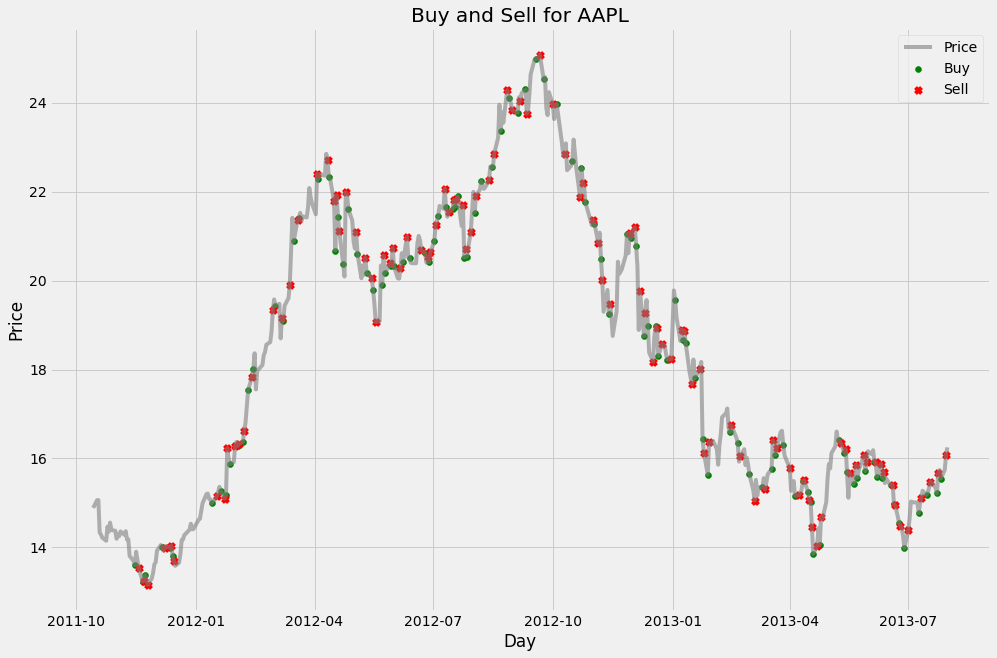

In [111]:
# Visualize and prices
plt.figure(figsize=(15,10))
plt.plot(data[['Date']], data[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)
#plt.plot(data[['Date']], df['RSI'][start_from:end_from], label='RSI', c='green')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

In [112]:
# Inputs
invest = 1000
start_from = 2667
end_from = -1
data = AAPL[start_from:end_from]

agent = ARIMA_Agent(invest)
buy_info, sell_info = agent.deploy(data)

# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data.iloc[-1].Open-data.iloc[0].Open)/data.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 1052.8900550000005
Percentage gain: 5.289005500000053 %

Baseline: 10.1364761249684 %


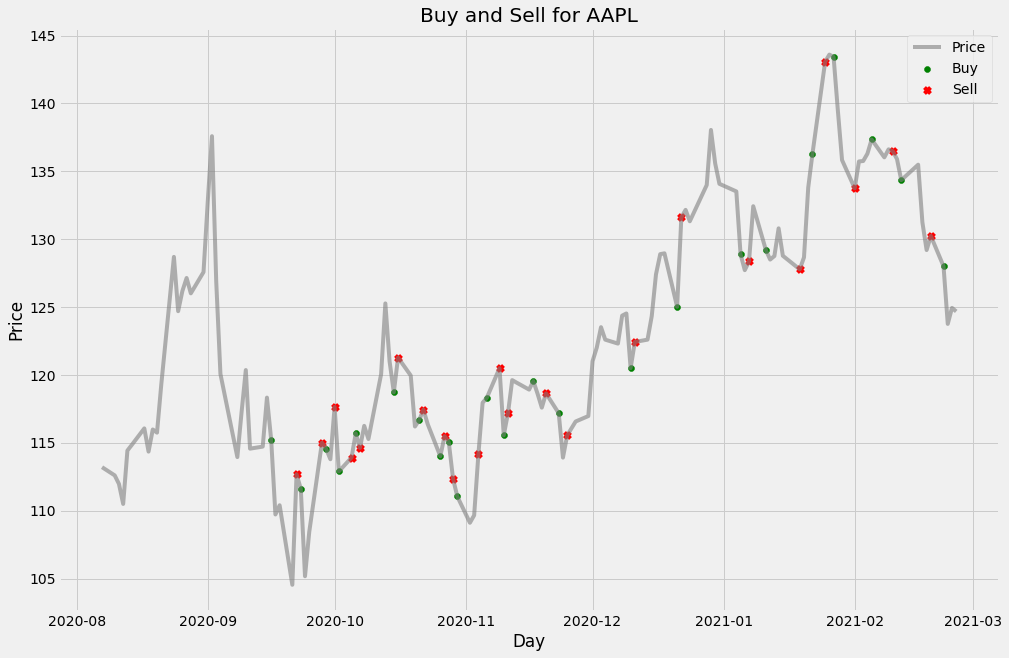

In [113]:
# Visualize and prices
plt.figure(figsize=(15,10))
plt.plot(data[['Date']], data[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)
#plt.plot(data[['Date']], df['RSI'][start_from:end_from], label='RSI', c='green')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

## Results

Timeframe before prediction: Need at least 3 weeks

Decision: Greater than or less than current price

Type of Stationarity Test: ADF or KPSS

With ADF test
- 450:900, gained 45.86%
- 2667:-1 , gained -2.58%
- Very little movement in order (0,1,0) the whole time

With default(kpss)
- 450:900, gained 64.635%
- 2667:-1, gained 5.29%